In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import config
api_key = config.api_key
import requests 

# remove scientific notation display for floats
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Data Sources and Notes:

## Box Office Mojo

### Box Office Mojo movie grosses

In [3]:
#read data
gross_bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz', compression='gzip')
gross_bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
title             3387 non-null object
studio            3382 non-null object
domestic_gross    3359 non-null float64
foreign_gross     2037 non-null object
year              3387 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


## Note: Not all movies have information for foreign gross earnings. To suplement foreign gross when not available we will use the ratio of the average (median) domestic to foreign gross, and then make a column for total gross earnings

In [4]:
# Foreign Gross is a string accounting for NaN.
# Creating foreign_release column in order to create expected foreign gross column.
gross_bom['no_foreign_release'] = gross_bom.foreign_gross.map(lambda x : pd.isnull(x))

In [5]:
print(gross_bom['no_foreign_release'].value_counts())
gross_bom.foreign_gross.isna().sum()

False    2037
True     1350
Name: no_foreign_release, dtype: int64


1350

In [6]:
# remove na rows from foreign_gross in order to calculate stats
no_na_foreign_gross = gross_bom.dropna(axis= 0, subset=['foreign_gross'])

In [7]:
# remove comma from string then convert to int
no_na_foreign_gross.foreign_gross = no_na_foreign_gross.foreign_gross.map(lambda val : int(float(val.replace(",", ""))))

/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [8]:
no_na_foreign_gross.agg(['mean', 'median', 'std'])

,domestic_gross,foreign_gross,year,no_foreign_release
mean,46973114.37780,74872810.14973,2013.49288,0.00000
median,16500000.00000,18700000.00000,2013.00000,0.00000
std,81599661.10596,137410600.84191,2.59241,0.00000


In [9]:
# find ratio of domestic to foreign mean
no_na_foreign_gross.domestic_gross.mean()/no_na_foreign_gross.foreign_gross.mean()

0.6273721299342642

In [10]:
# find ratio of domestic to foreign median
no_na_foreign_gross.domestic_gross.median()/no_na_foreign_gross.foreign_gross.median()

0.8823529411764706

In [11]:
# set foreign_gross na's to 0 in order to do arithmetic operations
gross_bom.foreign_gross.fillna("0", inplace=True)

In [12]:
# convert foreign_gross strings to int
gross_bom.foreign_gross = gross_bom.foreign_gross.map(lambda val : int(float(val.replace(",", ""))))

In [13]:
no_na_data = {'dom_median': no_na_foreign_gross.domestic_gross.median(), 'foreign_median': no_na_foreign_gross.foreign_gross.median()}

In [14]:
def total_gross(no_foreign_release, domestic_gross, foreign_gross):
    if no_foreign_release:
        return domestic_gross*(no_na_data['foreign_median']/no_na_data['dom_median'])
    else:
        return domestic_gross + foreign_gross

In [15]:
gross_bom['total_gross'] = gross_bom.apply(lambda row : total_gross(row.no_foreign_release, row.domestic_gross, row.foreign_gross), axis=1)

In [16]:
gross_bom.loc[gross_bom.no_foreign_release == True].head()

,title,studio,domestic_gross,foreign_gross,year,no_foreign_release,total_gross
222,Flipped,WB,1800000.00000,0,2010,True,2040000.00000
254,The Polar Express (IMAX re-issue 2010),WB,673000.00000,0,2010,True,762733.33333
267,Tiny Furniture,IFC,392000.00000,0,2010,True,444266.66667
269,Grease (Sing-a-Long re-issue),Par.,366000.00000,0,2010,True,414800.00000
280,Last Train Home,Zeit.,288000.00000,0,2010,True,326400.00000


# <span style="color:blue"> Done: Make total gross column </span>

## IMDB
Note: foreign keys look like nconst is for Person Name, and tconst is for Movie Title

### IMDB Basic info by Name

In [17]:
name_basics_imdb = pd.read_csv('zippedData/imdb.name.basics.csv.gz', compression='gzip')
name_basics_imdb.head(1)

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,nan,nan,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"


### IMDB some kind of info by Title
# <span style="color:red"> I think this is related to international releases? I can't tell yet </span>

In [18]:
title_imdb = pd.read_csv('zippedData/imdb.title.akas.csv.gz', compression='gzip')
title_imdb.head(2)

,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.00000
1,tt0369610,11,Jurashikku warudo,JP,NaN,imdbDisplay,NaN,0.00000


### IMDB Basic info by Title

In [19]:
title_basics_imdb = pd.read_csv('zippedData/imdb.title.basics.csv.gz', compression='gzip')
title_basics_imdb.head(1)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00000,"Action,Crime,Drama"


### Remove NaN rows from genres (as we are only looking at Animated films, we are not concerned with losing the data)

In [20]:
title_basics_imdb.dropna(axis= 0, subset=['genres'], inplace=True)

In [21]:
title_basics_imdb['is_animated'] = title_basics_imdb.apply(lambda row : 'Animation' in row.genres, axis=1)

## Create Animated Films DF

In [22]:
animated_films_df = title_basics_imdb.loc[title_basics_imdb['is_animated'] == True]

In [23]:
len(animated_films_df)

2799

## Create non-animated films for comparison

In [24]:
non_animated_films_df = title_basics_imdb.loc[title_basics_imdb['is_animated'] == False]

In [25]:
len(non_animated_films_df)

137937

### IMDB Crew (Writers and Directors)
This looks to be a connecting table

In [26]:
crew_imdb = pd.read_csv('zippedData/imdb.title.crew.csv.gz', compression='gzip')
crew_imdb.head(1)

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854


### IMDB Principles
(Actors, directors, producers, editors, actress, composer, cinematographer, writer, self, production designer, archive footage, archive sound )

In [27]:
title_principals_imdb = pd.read_csv('zippedData/imdb.title.principals.csv.gz', compression='gzip')
title_principals_imdb.head(1)

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"


### IMDB Rating
Key for titles along with rating and number of votes

In [28]:
title_ratings_imdb = pd.read_csv('zippedData/imdb.title.ratings.csv.gz', compression='gzip')
title_ratings_imdb.head(1)

,tconst,averagerating,numvotes
0,tt10356526,8.30000,31


## Rotten Tomatos

### Rotten Tomatos info
# <span style="color:red">  Note: No title, assuming id links to title somewhere</span>

In [29]:
info_rotten_tom = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t', compression='gzip')
info_roten_tom.head(1)

NameError: name 'info_roten_tom' is not defined

### Rotten Tomatos Reviews
# <span style="color:red">  Note: Also no titles, assuming id links to title but don't seem to have that data</span>

In [30]:
reviews_rotten_tom = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', compression='gzip', encoding="cp1252")
reviews_rotten_tom.head(1)

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"


## The Movie DataBase

### TMDB info

In [31]:
movies_movie_db = pd.read_csv('zippedData/tmdb.movies.csv.gz', compression='gzip')
# movies_movie_db.loc[movies_movie_db['id']==1]
movies_movie_db

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.53300,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.70000,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.73400,2010-03-26,How to Train Your Dragon,7.70000,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.51500,2010-05-07,Iron Man 2,6.80000,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.00500,1995-11-22,Toy Story,7.90000,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.92000,2010-07-16,Inception,8.30000,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.60000,2018-10-13,Laboratory Conditions,0.00000,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.60000,2018-05-01,_EXHIBIT_84xxx_,0.00000,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.60000,2018-10-01,The Last One,0.00000,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.60000,2018-06-22,Trailer Made,0.00000,1


In [57]:
# movies_movie_db.loc[movies_movie_db.genre_ids == [16]]
TMDB_movies_df = movies_movie_db[movies_movie_db['genre_ids'].str.contains('16')]

### TMDB budgets
# <span style="color:red"> What does the ID mean? </span>

In [58]:
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', compression='gzip')
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [59]:
movie_budgets.production_budget = movie_budgets.production_budget.map(lambda budget : int(budget.replace('$', '').replace(',', '')))

In [60]:
movie_budgets.worldwide_gross = movie_budgets.worldwide_gross.map(lambda budget : int(budget.replace('$', '').replace(',', '')))

# Combining DF containing name and genre with DF containing budgets and returns

In [62]:
TMDB_merge_df = pd.merge(TMDB_movies_df, movie_budgets, how='inner', left_on='title'.lower(), right_on='movie'.lower())

In [63]:
TMDB_merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 148
Data columns (total 16 columns):
Unnamed: 0           149 non-null int64
genre_ids            149 non-null object
id_x                 149 non-null int64
original_language    149 non-null object
original_title       149 non-null object
popularity           149 non-null float64
release_date_x       149 non-null object
title                149 non-null object
vote_average         149 non-null float64
vote_count           149 non-null int64
id_y                 149 non-null int64
release_date_y       149 non-null object
movie                149 non-null object
production_budget    149 non-null int64
domestic_gross       149 non-null object
worldwide_gross      149 non-null int64
dtypes: float64(2), int64(6), object(8)
memory usage: 19.8+ KB


In [465]:
animated_merge_df = pd.merge(animated_films_df, movie_budgets, how='inner', left_on='primary_title'.lower(), right_on='movie'.lower())


In [466]:
animated_merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148 entries, 0 to 147
Data columns (total 13 columns):
tconst               148 non-null object
primary_title        148 non-null object
original_title       148 non-null object
start_year           148 non-null int64
runtime_minutes      137 non-null float64
genres               148 non-null object
is_animated          148 non-null bool
id                   148 non-null int64
release_date         148 non-null object
movie                148 non-null object
production_budget    148 non-null int64
domestic_gross       148 non-null object
worldwide_gross      148 non-null int64
dtypes: bool(1), float64(1), int64(4), object(7)
memory usage: 15.2+ KB


In [462]:
non_animated_merge_df = pd.merge(non_animated_films_df, movie_budgets, how='inner', left_on='primary_title'.lower(), right_on='movie'.lower())

In [449]:
animated_merge_df.loc[animated_merge_df.production_budget == animated_merge_df.production_budget.max()]

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,is_animated,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
1,tt0398286,Tangled,Tangled,2010,100.00000,"Adventure,Animation,Comedy",True,15,"Nov 24, 2010",Tangled,260000000,"$200,821,936",586477240


In [ ]:
animated_merge_df.loc[animated_merge_df.production_budget == animated_merge_df.production_budget.max()]

In [467]:
len(animated_merge_df)

148

## Initial plot of budget to world wide gross for animated films:

In [446]:
animated_merge_df.production_budget.max()

260000000

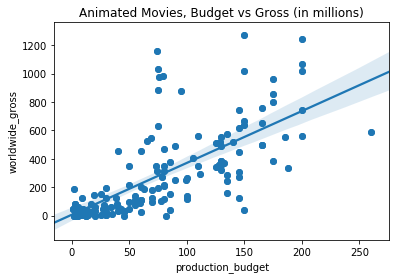

In [458]:
fig, ax = plt.subplots()
animated_scatter = ax.scatter(animated_merge_df['production_budget']/1e6, animated_merge_df['worldwide_gross']/1e6)
ax.set_xlabel("Production Budget (M)")
ax.set_ylabel("Worldwide Gross (M)")
ax.set_title("Animated Movies, Budget vs Gross (in millions)")
sns.regplot(animated_merge_df['production_budget']/1e6, animated_merge_df['worldwide_gross']/1e6)

## Initial plot of budget to world wide gross for non-animated films:

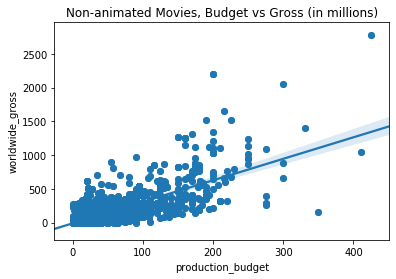

In [457]:
fig, ax = plt.subplots()
ax.scatter(non_animated_merge_df['production_budget']/1e6, non_animated_merge_df['worldwide_gross']/1e6)
ax.set_xlabel("Production Budget (M)")
ax.set_ylabel("Worldwide Gross (M)")
ax.set_title("Non-animated Movies, Budget vs Gross (in millions)")
sns.regplot(non_animated_merge_df['production_budget']/1e6, non_animated_merge_df['worldwide_gross']/1e6)

# TMDB API Results

In [180]:
def call_TMDB_api(page):
    return requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' +  api_key + '&with_genres=16&page='+ page).json()['results']

first_call = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' +  api_key + '&with_genres=16')
num_pages = first_call.json()['total_pages']

In [ ]:
# commenting this out so I don't accidentally make another 500 api calls
# results = []
# for i in range(num_pages):
#     results += call_TMDB_api(str(i+1))

In [141]:
test_result_list = results[0:100]

In [142]:
test_result_list

[{'popularity': 150.214,
  'vote_count': 701,
  'video': False,
  'poster_path': '/jHo2M1OiH9Re33jYtUQdfzPeUkx.jpg',
  'id': 385103,
  'adult': False,
  'backdrop_path': '/fKtYXUhX5fxMxzQfyUcQW9Shik6.jpg',
  'original_language': 'en',
  'original_title': 'Scoob!',
  'genre_ids': [12, 16, 35, 9648, 10751],
  'title': 'Scoob!',
  'vote_average': 8,
  'overview': 'In Scooby-Doo’s greatest adventure yet, see the never-before told story of how lifelong friends Scooby and Shaggy first met and how they joined forces with young detectives Fred, Velma, and Daphne to form the famous Mystery Inc. Now, with hundreds of cases solved, Scooby and the gang face their biggest, toughest mystery ever: an evil plot to unleash the ghost dog Cerberus upon the world. As they race to stop this global “dogpocalypse,” the gang discovers that Scooby has a secret legacy and an epic destiny greater than anyone ever imagined.',
  'release_date': '2020-05-15'},
 {'popularity': 86.979,
  'vote_count': 9378,
  'video'

In [143]:
details = []
for movie in test_result_list:
    details.append(requests.get('https://api.themoviedb.org/3/movie/'+ str(movie['id']) +'?api_key='+ api_key).json())
    
    
    
    

In [158]:
for key, value in details[1].items():
    print(key, type(value))
keys = details[1].keys()

adult <class 'bool'>
backdrop_path <class 'str'>
belongs_to_collection <class 'dict'>
budget <class 'int'>
genres <class 'list'>
homepage <class 'str'>
id <class 'int'>
imdb_id <class 'str'>
original_language <class 'str'>
original_title <class 'str'>
overview <class 'str'>
popularity <class 'float'>
poster_path <class 'str'>
production_companies <class 'list'>
production_countries <class 'list'>
release_date <class 'str'>
revenue <class 'int'>
runtime <class 'int'>
spoken_languages <class 'list'>
status <class 'str'>
tagline <class 'str'>
title <class 'str'>
video <class 'bool'>
vote_average <class 'float'>
vote_count <class 'int'>


In [159]:
test_df = pd.DataFrame(details, columns= keys)

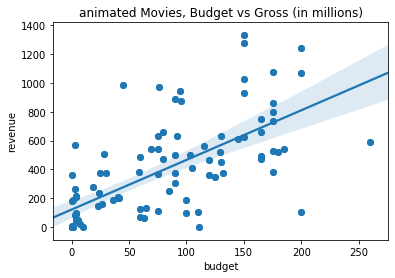

In [169]:
fig, ax = plt.subplots()
ax.scatter(test_df['budget']/1e6, test_df['revenue']/1e6)
ax.set_xlabel("Production Budget (M)")
ax.set_ylabel("Worldwide Gross (M)")
ax.set_title("animated Movies, Budget vs Gross (in millions)")
sns.regplot(test_df['budget']/1e6, test_df['revenue']/1e6)